In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az
from collections import Counter
from scipy.interpolate import griddata
import pymc3 as pm
import theano as tt

sns.set()

In [2]:
# Functions
def sort_vals(vals, ascending = True):
    """sorts valus from high to low
    returns:
    idx - values in ascending or descending order
    """
    if ascending:
        idx = np.argsort(-vals)
    else:
        idx = np.argsort(vals)
    return idx


 # Chapter 5
 ### Cde 5.1

In [3]:
d = pd.read_csv('.\data\WaffleDivorce.csv', sep = ';')
d.columns = d.columns.str.lower()
d.head()

,location,loc,population,medianagemarriage,marriage,marriage se,divorce,divorce se,wafflehouses,south,slaves1860,population1860,propslaves1860
0,Alabama,AL,4.78,25.3,20.2,1.27,12.7,0.79,128,1,435080,964201,0.45
1,Alaska,AK,0.71,25.2,26.0,2.93,12.5,2.05,0,0,0,0,0.00
2,Arizona,AZ,6.33,25.8,20.3,0.98,10.8,0.74,18,0,0,0,0.00
3,Arkansas,AR,2.92,24.3,26.4,1.70,13.5,1.22,41,1,111115,435450,0.26
4,California,CA,37.25,26.8,19.1,0.39,8.0,0.24,0,0,0,379994,0.00


In [4]:
d['medianagemarriage_s'] = (d.medianagemarriage - d.medianagemarriage.mean())/ d.medianagemarriage.std()

In [5]:
shared_x = tt.shared(d.medianagemarriage_s.values)
shared_y = tt.shared(d.divorce.values)
with pm.Model() as m51:
    alpha = pm.Normal('alpha', mu = 10, sigma = 10)
    beta = pm.Normal('beta', mu = 0, sigma = 1)
    mu = pm.Deterministic('mu', alpha + beta*shared_x)
    sigma = pm.Uniform('sigma', lower = 0, upper = 10)
    divorce = pm.Normal('divorce',mu = mu, sigma = sigma, observed = shared_y)
    trace51 = pm.sample(draws = 1000,tune = 1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta, alpha]
Sampling 4 chains: 100%|██████████████████████████████████████████████████████| 8000/8000 [00:05<00:00, 1592.42draws/s]


In [6]:
varnames = ['alpha', 'beta','sigma']
pm.summary(trace51, varnames = varnames)

C:\Users\JOSH\Anaconda3\lib\site-packages\pymc3\stats.py:991: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  axis=1, join_axes=[dforg.index])


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
alpha,9.685201,0.218310,0.003004,9.276835,10.128690,5299.138823,0.999542
beta,-1.039788,0.212533,0.003127,-1.476442,-0.645563,4885.466110,0.999825
sigma,1.519224,0.160163,0.002323,1.222701,1.821893,4777.325316,1.000099


 ## Code 5.2

In [7]:
new_x_values = np.linspace(-3,3.5,num = 30)
shared_x.set_value(new_x_values)
shared_y.set_value(np.repeat(0, repeats = len(new_x_values)))
with m51:
    post_pred = pm.sample_posterior_predictive(trace51,samples = 1000,model=m51)

100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 107.45it/s]


In [8]:
mu_hpd = az.hpd(trace51['mu'], credible_interval=.89)
post_pred_hpd = az.hpd(post_pred['divorce'], credible_interval=.89)

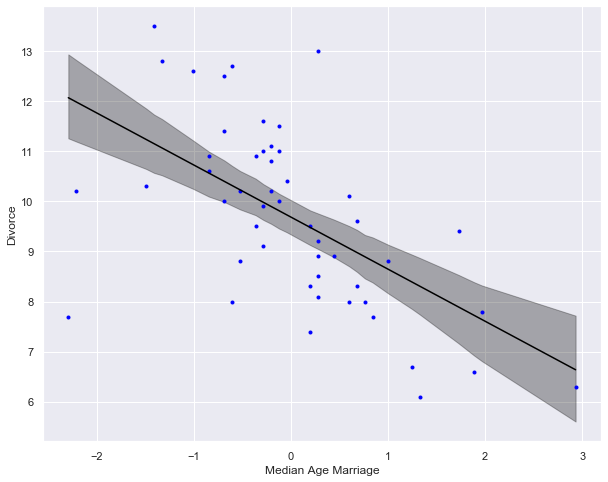

In [9]:
idx = sort_vals(d.medianagemarriage_s)
sorted_x_vals = d.medianagemarriage_s[idx]

plt.figure(figsize=(10,8))
plt.plot(d.medianagemarriage_s.values,d.divorce.values, color = 'blue', marker = '.', linestyle = '')
plt.plot(sorted_x_vals, trace51['alpha'].mean() + np.mean(trace51['beta'])*sorted_x_vals, color = 'black', alpha = 1)
plt.fill_between(sorted_x_vals, mu_hpd[idx,0], mu_hpd[idx,1], color='black', alpha=0.3)
plt.xlabel('Median Age Marriage')
plt.ylabel('Divorce')

plt.show()

 ## Code 5.3

In [11]:
d['marriage_s'] = (d.marriage - d.marriage.mean())/ d.marriage.std()

In [12]:
shared_x = tt.shared(d.marriage_s.values)
shared_y = tt.shared(d.divorce.values)
with pm.Model() as m53:
    alpha = pm.Normal('alpha', mu = 10, sigma = 10)
    beta = pm.Normal('MAM_beta', mu = 0, sigma = 1)
    mu = pm.Deterministic('mu', alpha + beta*shared_x)
    sigma = pm.Uniform('sigma', lower = 0, upper = 10)
    divorce = pm.Normal('divorce',mu = mu, sigma = sigma, observed = shared_y)
    trace53 = pm.sample(draws = 1000,tune = 1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, MAM_beta, alpha]
Sampling 4 chains: 100%|██████████████████████████████████████████████████████| 8000/8000 [00:05<00:00, 1505.54draws/s]


In [13]:
varnames_53 = ['alpha', 'MAM_beta','sigma']
pm.summary(trace53, varnames = varnames_53)

C:\Users\JOSH\Anaconda3\lib\site-packages\pymc3\stats.py:991: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  axis=1, join_axes=[dforg.index])


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
alpha,9.691769,0.252023,0.003646,9.219076,10.210510,5187.046371,1.000007
MAM_beta,0.641079,0.244219,0.003831,0.165534,1.110377,3946.278086,1.000207
sigma,1.752277,0.183203,0.002428,1.421600,2.116372,5102.428923,0.999669


In [14]:
new_x_values = np.linspace(-3,3.5,num = 30)
shared_x.set_value(new_x_values)
shared_y.set_value(np.repeat(0, repeats = len(new_x_values)))
with m53:
    post_pred = pm.sample_posterior_predictive(trace53,samples = 1000,model=m53)

100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 104.98it/s]


In [15]:
mu_hpd = az.hpd(trace53['mu'], credible_interval=.89)
post_pred_hpd = az.hpd(post_pred['divorce'], credible_interval=.89)

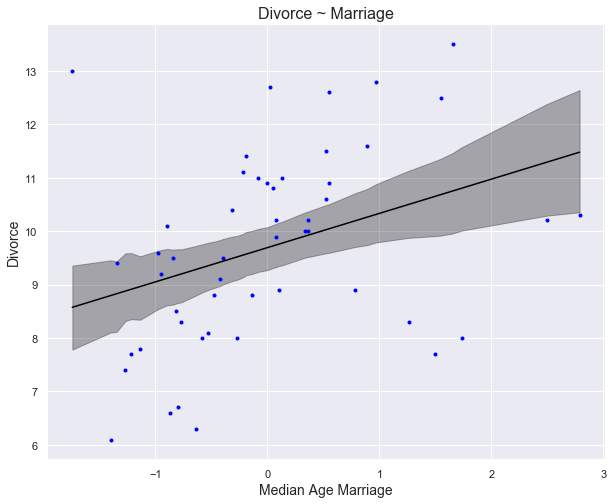

In [17]:
idx = sort_vals(d.marriage_s)
sorted_x_vals = d.marriage_s[idx]

plt.figure(figsize=(10,8))
plt.plot(d.marriage_s.values,d.divorce.values, color = 'blue', marker = '.', linestyle = '')
plt.plot(sorted_x_vals, trace53['alpha'].mean() + np.mean(trace53['MAM_beta'])*sorted_x_vals, color = 'black', alpha = 1)
plt.fill_between(sorted_x_vals, mu_hpd[idx,0], mu_hpd[idx,1], color='black', alpha=0.3)
plt.xlabel('Median Age Marriage', fontsize = 14)
plt.ylabel('Divorce', fontsize = 14)
plt.title('Divorce ~ Marriage', fontsize = 16)

plt.show()

 ## Code 5.4

In [18]:
shared_x = tt.shared(d[['marriage_s','medianagemarriage_s']].values)
shared_y = tt.shared(d.divorce.values)

with pm.Model() as m54:
    alpha = pm.Normal('alpha', mu = 10, sigma = 10)
    beta = pm.Normal('MARR_beta', mu = 0, sigma = 1)
    beta2 = pm.Normal('MAM_beta', mu = 0, sigma = 1)
    mu = pm.Deterministic('mu', alpha + beta*shared_x.get_value()[:,0] + beta2*shared_x.get_value()[:,1])
    sigma = pm.Uniform('sigma', lower = 0, upper = 10)
    divorce = pm.Normal('divorce',mu = mu, sigma = sigma, observed = shared_y)
    trace54 = pm.sample(draws = 1000,tune = 1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, MAM_beta, MARR_beta, alpha]
Sampling 4 chains: 100%|██████████████████████████████████████████████████████| 8000/8000 [00:06<00:00, 1168.41draws/s]


In [19]:
varnames_54 = ['alpha', 'MARR_beta','MAM_beta','sigma']
pm.summary(trace54, varnames = varnames_54, alpha = .11).round(3)

C:\Users\JOSH\Anaconda3\lib\site-packages\pymc3\stats.py:991: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  axis=1, join_axes=[dforg.index])


,mean,sd,mc_error,hpd_5.5,hpd_94.5,n_eff,Rhat
alpha,9.687,0.215,0.004,9.352,10.032,3479.768,1.0
MARR_beta,-0.121,0.286,0.005,-0.564,0.349,2754.057,1.0
MAM_beta,-1.122,0.288,0.005,-1.568,-0.656,2644.282,1.0
sigma,1.522,0.161,0.003,1.281,1.779,3235.747,1.0


In [20]:
#notice how after adding im the marriage rate of the state our signs flip from positive to negative.
# this is classic example of mulitcollinearity
pm.summary(trace53, varnames = varnames_53, alpha = .11).round(3)

C:\Users\JOSH\Anaconda3\lib\site-packages\pymc3\stats.py:991: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  axis=1, join_axes=[dforg.index])


,mean,sd,mc_error,hpd_5.5,hpd_94.5,n_eff,Rhat
alpha,9.692,0.252,0.004,9.273,10.077,5187.046,1.0
MAM_beta,0.641,0.244,0.004,0.242,1.012,3946.278,1.0
sigma,1.752,0.183,0.002,1.444,2.016,5102.429,1.0


## Code 5.5

C:\Users\JOSH\Anaconda3\lib\site-packages\arviz\plots\forestplot.py:207: MatplotlibDeprecationWarning: 
The tick1On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick1line.set_visible instead.
  ticks.tick1On = False
C:\Users\JOSH\Anaconda3\lib\site-packages\arviz\plots\forestplot.py:208: MatplotlibDeprecationWarning: 
The tick2On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick2line.set_visible instead.
  ticks.tick2On = False


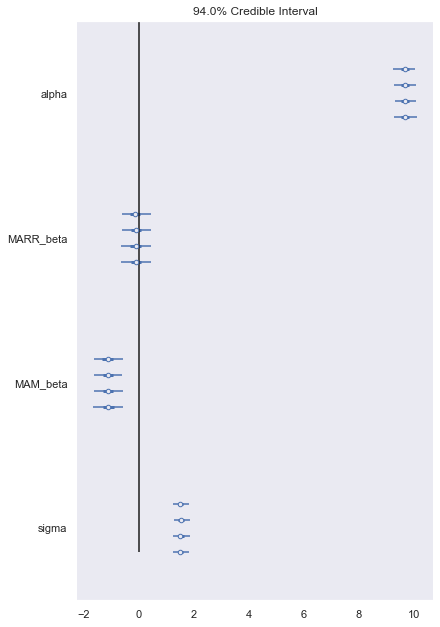

In [21]:
# interpretaion from the book, "Once we know median age of marraiage for a state there is little or no additional 
# predictive power in also knowing the rate of marriage in that state"
az.plot_forest(trace54,var_names=varnames_54)
plt.vlines(x = 0, ymin = 0, ymax = 5)

 ## Code 5.6

In [22]:
shared_x = tt.shared(d.medianagemarriage_s.values)
shared_y = tt.shared(d.divorce.values)
with pm.Model() as m56:
    alpha = pm.Normal('alpha', mu = 10, sigma = 10)
    beta = pm.Normal('MAM_beta', mu = 0, sigma = 1)
    mu = pm.Deterministic('mu', alpha + beta*shared_x)
    sigma = pm.Uniform('sigma', lower = 0, upper = 10)
    divorce = pm.Normal('divorce',mu = mu, sigma = sigma, observed = shared_y)
    trace56 = pm.sample(draws = 1000,tune = 1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, MAM_beta, alpha]
Sampling 4 chains: 100%|██████████████████████████████████████████████████████| 8000/8000 [00:05<00:00, 1574.09draws/s]


In [23]:
varnames_56 = ['alpha', 'MAM_beta','sigma']
pm.summary(trace56, varnames = varnames_56)

C:\Users\JOSH\Anaconda3\lib\site-packages\pymc3\stats.py:991: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  axis=1, join_axes=[dforg.index])


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
alpha,9.690396,0.211678,0.002921,9.285920,10.117674,5439.225685,1.000387
MAM_beta,-1.036644,0.214478,0.003378,-1.446151,-0.606606,4914.607514,0.999542
sigma,1.514648,0.160629,0.002128,1.231569,1.836489,5693.059916,0.999787


 ## Code 5.7

In [28]:
# computer expected value at MAP, for each State
#mu = trace56['alpha'] + trace56['MAM_beta']*d.medianagemarriage_s
# compute residual for each state
d['m_resid'] = d.medianagemarriage_s - mu

ValueError: operands could not be broadcast together with shapes (4000,) (50,) 

In [31]:
pm.trace_to_dataframe(trace56)

,alpha,MAM_beta,mu__0,mu__1,mu__2,mu__3,mu__4,mu__5,mu__6,mu__7,...,mu__41,mu__42,mu__43,mu__44,mu__45,mu__46,mu__47,mu__48,mu__49,sigma
0,9.735222,-0.786641,10.212154,10.275408,9.895886,10.844690,9.263350,9.959139,8.757321,9.389857,...,10.275408,10.275408,11.477226,9.200096,9.516364,9.832632,10.401915,9.579618,10.907944,1.627985
1,9.740868,-1.291358,10.523805,10.627642,10.004616,11.562183,8.966238,10.108453,8.135535,9.173913,...,10.627642,10.627642,12.600561,8.862400,9.381589,9.900778,10.835318,9.485427,11.666020,1.461148
2,9.537727,-1.086707,10.196585,10.283967,9.759676,11.070403,8.885858,9.847058,8.186804,9.060622,...,10.283967,10.283967,11.944221,8.798477,9.235386,9.672295,10.458731,9.322767,11.157785,1.440004
3,9.911408,-0.906369,10.460930,10.533810,10.096525,11.189739,9.367716,10.169406,8.784669,9.513478,...,10.533810,10.533810,11.918548,9.294835,9.659240,10.023644,10.679572,9.732121,11.262620,1.620532
4,9.666245,-0.999810,10.272420,10.352814,9.870447,11.076364,9.066502,9.950842,8.423347,9.227291,...,10.352814,10.352814,11.880309,8.986108,9.388080,9.790053,10.513603,9.468475,11.156759,1.481369
5,9.751720,-1.537946,10.684160,10.807826,10.065831,11.920819,8.829172,10.189497,7.839845,9.076504,...,10.807826,10.807826,13.157478,8.705506,9.323836,9.942165,11.055158,9.447502,12.044485,1.365729
6,9.390622,-0.923953,9.950805,10.025100,9.579331,10.693754,8.836382,9.653626,8.242023,8.984972,...,10.025100,10.025100,11.436702,8.762087,9.133561,9.505036,10.173690,9.207856,10.768048,1.487852
7,9.260753,-0.933196,9.826540,9.901578,9.451349,10.576920,8.700969,9.526387,8.100664,8.851045,...,9.901578,9.901578,11.327301,8.625931,9.001121,9.376311,10.051654,9.076159,10.651958,1.554858
8,9.780941,-0.738454,10.228658,10.288037,9.931764,10.822447,9.337975,9.991143,8.862944,9.456733,...,10.288037,10.288037,11.416236,9.278596,9.575491,9.872385,10.406795,9.634869,10.881826,1.529703
9,9.726034,-0.930606,10.290250,10.365080,9.916102,11.038548,9.167804,9.990931,8.569165,9.317463,...,10.365080,10.365080,11.786846,9.092974,9.467123,9.841272,10.514740,9.541953,11.113378,1.482677


4000

 ## Code 5.8

In [ ]:
idx = np.argsort(d.medianagemarriage_s)
plt.plot('medianagemarriage_s', 'marriage_s', data = d, marker = '.', linestyle = '')
plt.plot(d.loc[idx,'medianagemarriage_s'], mu[idx], linestyle = '-',color = 'black')

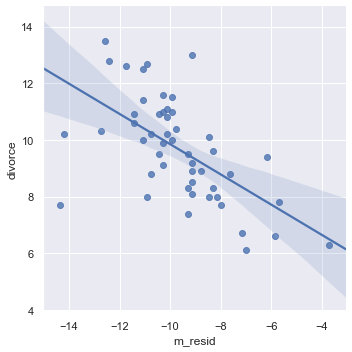

In [25]:
sns.lmplot('m_resid','divorce',data=d)
